In [138]:
import numpy as np
import pandas as pd
import torch
device = torch.device("mps")

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
pop = pd.read_csv('data/songs_liwc_25_03_13.csv').iloc[:, 2:]
pop.columns

Index(['artist', 'album', 'song', 'lyrics', 'Segment', 'WC', 'Analytic',
       'Clout', 'Authentic', 'Tone',
       ...
       'nonflu', 'filler', 'AllPunc', 'Period', 'Comma', 'QMark', 'Exclam',
       'Apostro', 'OtherP', 'Emoji'],
      dtype='object', length=123)

In [142]:
torch.backends.mps.is_available()
torch.backends.mps.is_built()
device

device(type='mps')

In [143]:
# processing: currently leaving punctuation alone
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess

pop['lyrics'] = pop['lyrics'].astype(str).apply(remove_stopwords)
pop['lyrics-tokenized'] = pop['lyrics'].apply(simple_preprocess)


In [ ]:
# emotion detection with distelroberta
# https://huggingface.co/j-hartmann/emotion-english-distilroberta-base
from transformers import pipeline
emotion_model = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base",
                         truncation = True,
                         device=0)  # Use GPU if available, otherwise use CPU

pop['emotion'] = emotion_model(pop['lyrics'].tolist(), batch_size=8)
pop['emotion'] = pop['emotion'].apply(lambda x: x[0]['label'])

#pop['emotion'] = pop['lyrics'].apply(lambda text: emotion_model(text)[0]['label'])

In [ ]:
# add NRC
#https://www.geeksforgeeks.org/emotion-classification-using-nrc-lexicon-in-python/
from nrclex import NRCLex

#google ai popup:
def analyze_emotion(text):
    if isinstance(text, str):
        emotion_lexicon = NRCLex(text)
        return emotion_lexicon.raw_emotion_scores
    else:
        return {} 

#pop = pop.join(pop['emotion_scores'].apply(pd.Series))
pop['emotion_scores'] = pop['lyrics'].apply(analyze_emotion)

In [27]:
pop = pop.join(pop['emotion_scores'].apply(pd.Series))

In [28]:
pop.columns

Index(['Unnamed: 0', 'index', 'artist', 'album', 'song', 'lyrics', 'Segment',
       'WC', 'Analytic', 'Clout',
       ...
       'trust', 'anticipation', 'fear', 'surprise', 'positive', 'negative',
       'joy', 'sadness', 'anger', 'disgust'],
      dtype='object', length=137)

In [ ]:
# work on PCA -- have distilbert, NRC + LIWC

pop.to_csv('data/songs_expanded_25_04_01.csv', index=False)

In [58]:
# now LIWC, NRC, distilbert all together : time for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pop_scale =  pop.select_dtypes(include='number').fillna(0)
scl = pd.DataFrame(scaler.fit_transform(pop_scale))
#pop_pca_scaled = pd.DataFrame(data=scl,columns=pop.columns[1:])

In [103]:
scl.columns = pop_scale.columns
scl.head()


,Unnamed: 0,index,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,...,trust,anticipation,fear,surprise,positive,negative,joy,sadness,anger,disgust
0,-1.742064,-1.868579,0.0,-0.765406,1.631144,-0.330791,0.918852,-1.228857,-0.175148,1.180456,...,-0.669545,-0.736665,-0.700296,-0.409656,-1.041824,-0.966459,-1.026358,-1.012948,-0.871721,-0.783610
1,-1.741233,-1.868025,0.0,-0.217822,-0.968323,1.799534,-0.351041,1.930779,-1.083758,0.292756,...,-0.377931,-0.414731,-0.961041,-0.851930,-0.461932,-0.617525,-0.253595,-0.710191,-0.637167,-0.488326
2,-1.740402,-1.867471,0.0,0.097039,1.334962,-1.002378,0.918852,-1.041347,0.823150,-0.944868,...,-0.086318,-0.414731,0.342684,-0.851930,-0.461932,-0.094125,-0.768771,0.500835,0.066496,-0.193042
3,-1.739571,-1.866918,0.0,-0.573752,-0.040312,-0.595883,-0.127126,-1.228857,0.046696,-0.217396,...,-0.961158,-0.736665,-0.439551,-0.851930,-1.235121,-0.268592,-0.511183,-0.407435,-0.637167,-0.783610
4,-1.738739,-1.866364,0.0,-0.464235,-0.764623,1.733624,0.735207,-0.819037,-0.840681,-0.016650,...,-0.669545,-0.736665,-0.439551,-0.409656,-0.461932,-0.094125,-0.768771,0.198078,-0.402612,-0.193042


In [104]:
#https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/Principal%20Component%20Analysis.ipynb 
#from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pop_pca = pca.fit(scl)

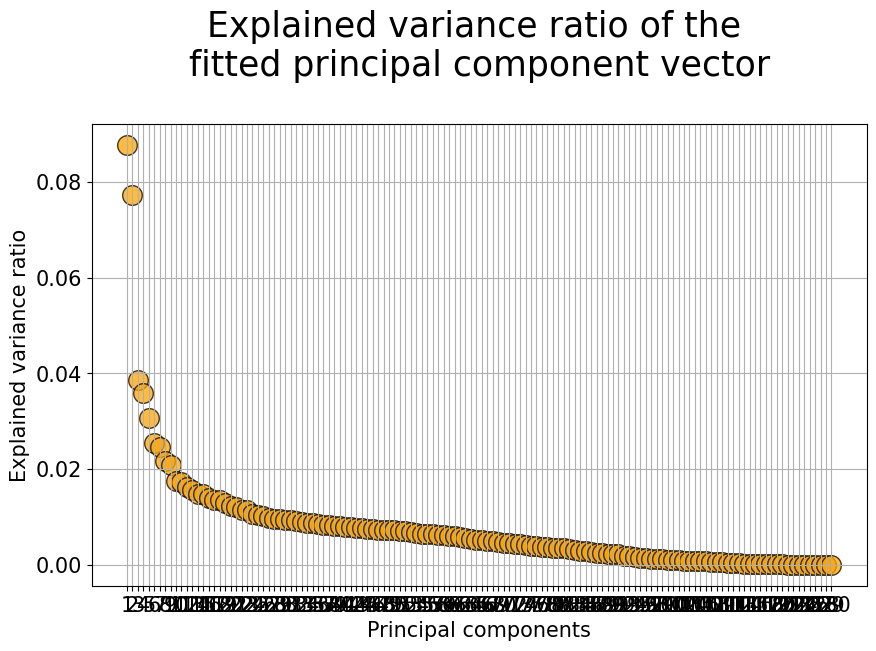

In [105]:
# explained variance ratio 
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(pop_pca.explained_variance_ratio_))],
            y=pop_pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(pop_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [106]:
pop_pca_trans = pd.DataFrame(pca.transform(scl))


[pca] >Extracting column labels from dataframe.
[pca] >The PCA reduction is performed on the [130] columns of the input dataframe.
[pca] >Fit using PCA.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled on

[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


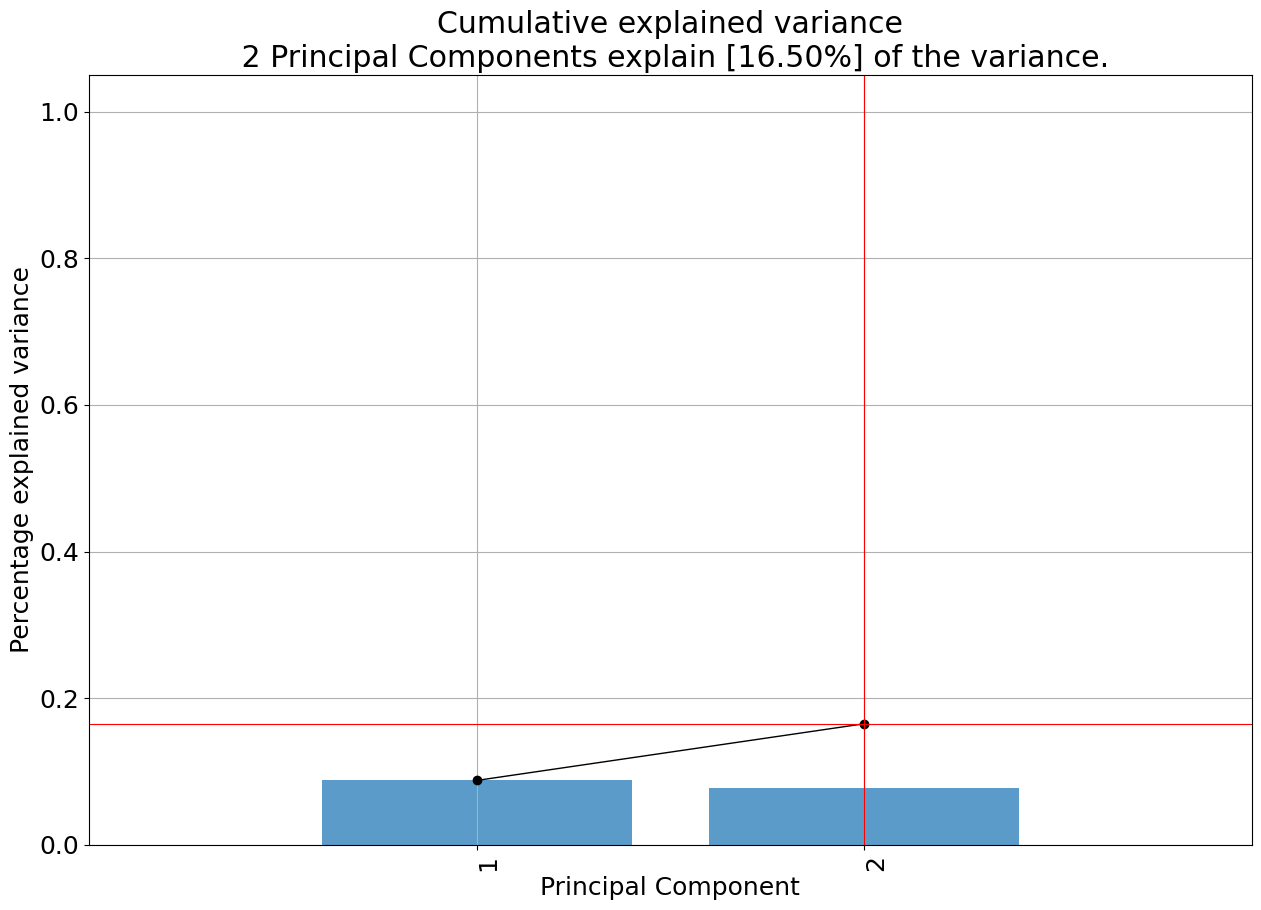

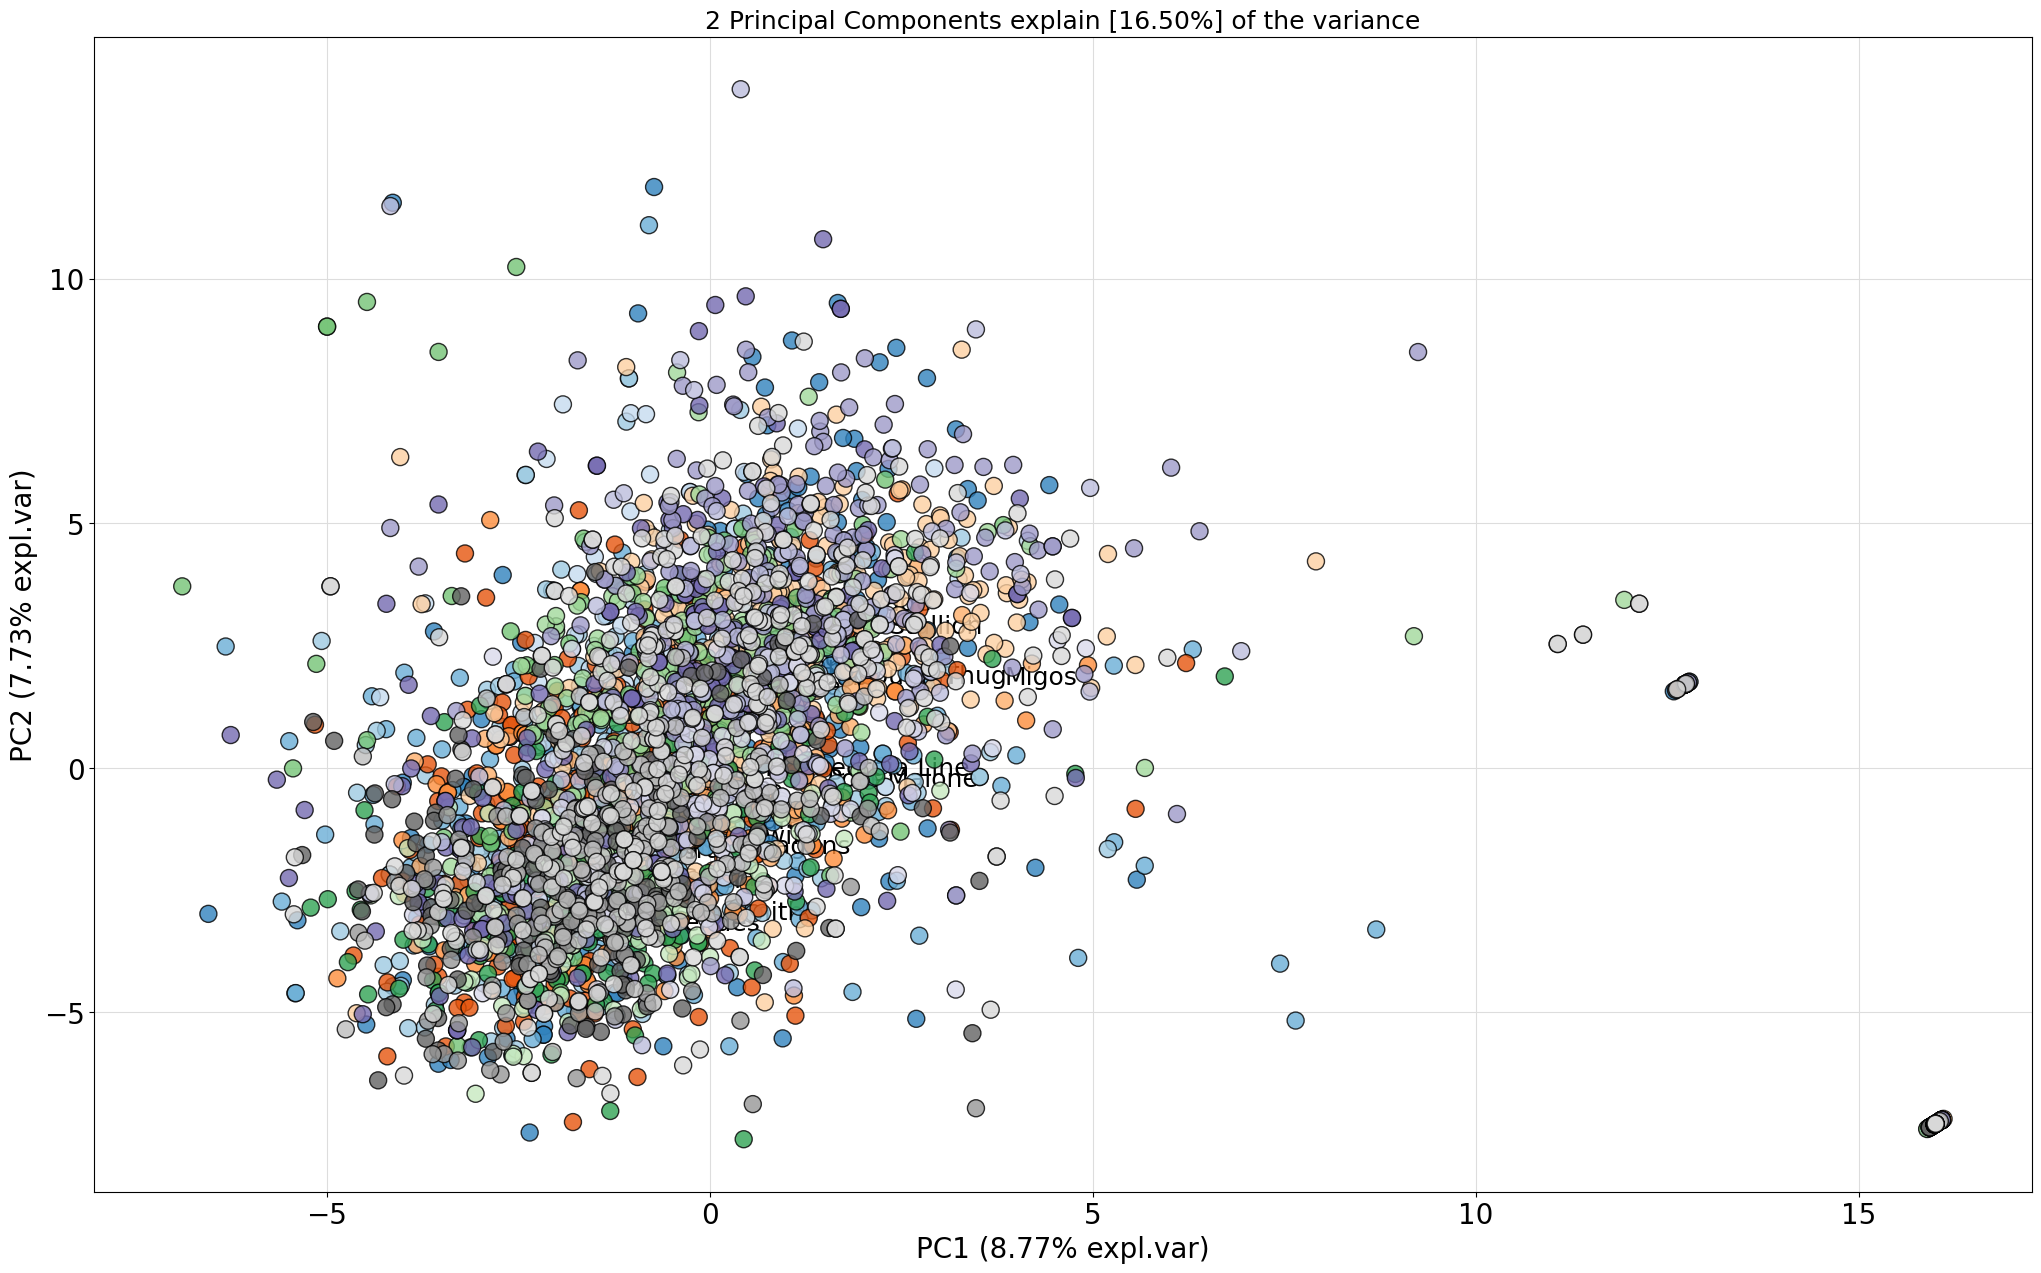

In [107]:
#https://erdogant.github.io/pca/pages/html/index.html
from pca import pca
model = pca(n_components=0.95)
# ... or explicitly specify the number of PCs
model = pca(n_components=2)

# Fit and transform
results = model.fit_transform(X=scl, row_labels = pop["artist"])

# Plot the explained variance
fig, ax = model.plot()

# Scatter the first two PCs
fig, ax = model.scatter()



In [ ]:
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_)) 

[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd]

[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.
4 [0.56779404 0.72239114]
119 [ 0.26457129 -0.50578995]


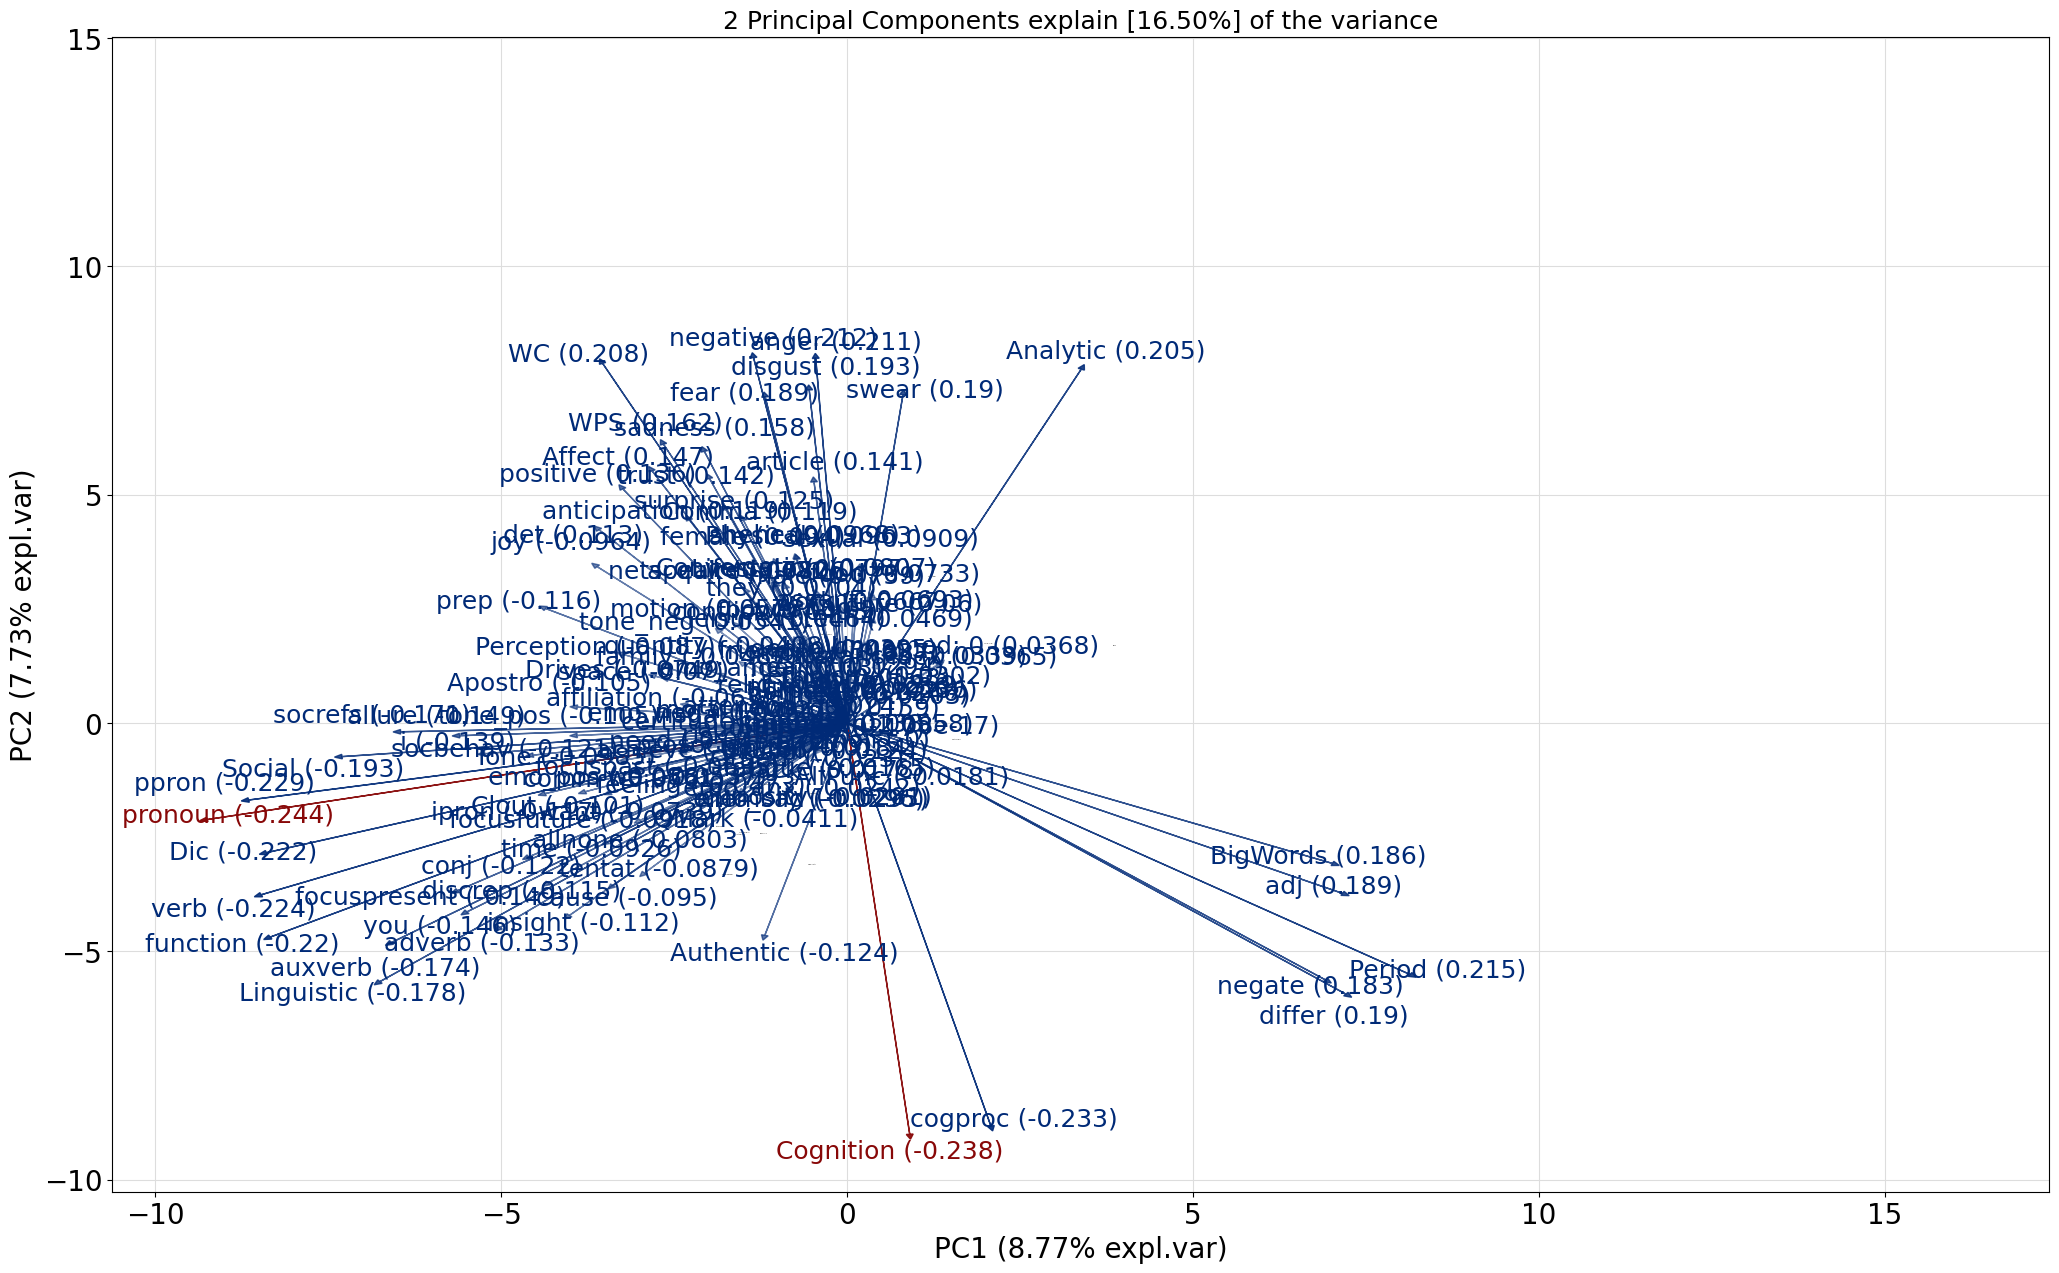

In [109]:
# Create a biplot
fig, ax = model.biplot(n_feat=130, cmap=None)


In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(pop_pca_trans[0],pop_pca_trans[1],c=pop['artist'], edgecolors='k',alpha=0.75,s=150)
plt.grid(True)
plt.title("Class separation using first two principal components\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.show()